# Stirred (not shaken)

**MOD510 - Project 3 G05**   
- Parthasarathi Jena
- Jing Hou
- Hodjat Moradi  

Date: Nov.9.2023

In [1]:
# load libraries
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.special import expi
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from numba import jit
from matplotlib import cm
#%matplotlib notebook # uncomment this if you want to  use interactive plots 

## Abstract: 

In this practical exercise, we delve into the intricacies of real-world systems like the human vascular network. Our main goal is hands-on learning and understanding these complex systems using numerical methods.

We focus on simplifying models for practical use while maintaining real-world relevance. Our study centers on the aortic arch's behavior and its potential for detecting aortic aneurysms.

Simultaneously, we investigate the feasibility of matching results with computational fluid dynamics (CFD) simulations. We use a simple approach, employing Continuous-Stirred-Tank-Reactor (CSTR) models with varying mixing tank numbers. By comparing mathematical solution methods like Euler, Runge-Kutta second order (RK2), and Runge-Kutta fourth order (RK4), we determine RK4 as the most accurate method.

Optimal parameter search is performed using Newton Raphson's and gradient descent optimization, and our CSTR model is fitted to scenarios involving healthy and aortas with aneurysm . While the model effectively reproduces effluent concentration in the healthy aorta, it exhibits some deviation when applied to aortas with aneurysms.

This exercise underscores the importance of practical learning, emphasizing its value in understanding complex system modeling.

## Introduction:

An aorta is a blood vessel that carries blood from the heart to the rest of the body. This blood vessel is essential in proper functioning of the human body and diseases in it can cause severe health issues. A common form of heart disease is development of an aneurysm in the aorta The figure below [4] shows the various forms of aneurysms that can occur on the aorta.

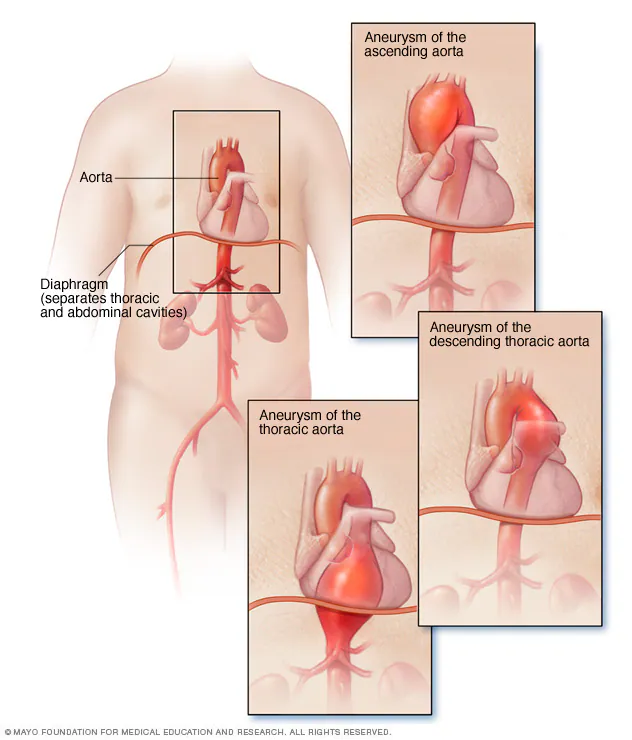

Patel et al. [5] describe the development of aneurysm in an aorta and their causes thusly:

>Degenerative aneurysms comprise the majority of those seen in the ascending aorta and have a specific pathological profile. Whereas the elastin content in the ascending aorta is high, that seen in ascending aortic aneurysms is significantly reduced. In addition, the media of the aneurysm displays a loss of smooth muscle cells and fragmentation of the elastic fibers from a process known as cystic medial degeneration. Although this process is seen normally as a consequence of aging, it is accelerated in some and results in the phenotypic expression of an ascending aortic aneurysm.

So, an aneurysm in an aorta can be understood as a balooning of the blood vessel due to it loosing elasticity.  

In this project, we will implement ordinary differential equations (ODEs) models to compare with Computational Fluid Dynamics (CFD) simulations result[1]. The idea is to implement simple approach of Continuous- Stirred-Tank-Reactor (CSTR) model with n tanks in series [2] to reproduce and predict the effluent concentrations on aorta arch. Three different algorithms will be implemented- Euler, RK2 and RK4 and error scaling of these algorithms will be discussed. With the given CFD simulation data, we will investigate and look for the optimal value of $N$ and $\tau$ by using the our model. and Based on that, it is possible to obtain the crucial information about cardiac output- flooding rate (q) and volume of aortic arch (V). CSTR model also will be fit to two scenarios - healthy aorta and unhealthy aorta with aneurysm.

## Theory: 
The mathematical equations for n-tanks in a series follows from mass conservation 

$$ \frac{\text {change of mass in the system}} {time} = \frac{mass_{in} - mass_{out} }{time} $$


$$V_0\frac{dC_0}{dt} = q(C_{in}-C_0) \\
    V_1\frac{dC_1}{dt} = q(C_0-C_1) \\
    \vdots\\
V_{n-1}\frac{dC_{n-1}}{dt} = q(C_{n-2}-C_{n-1})$$


In the above set of ODEs, $V_i$ is the volume of tank number i, $C_i = C_i(t)$ is the concentration in the tank at time t (unit mass/volume), $q$ is a constant volumetric injection flow rate (cardiac output and unit volume/time), and $C_{in} = C_{in}(t)$ is the injected concentration at time t.

Scaling of volumes.
In this project, we want to use n as a parameter without changing the total volume of the system, thus we want the $n = 1$ system to have the same
volume as, e.g., n = 10. We therefore need to scale the volumes of the individual tanks. To simplify, we shall assume that each tank has the same
volume V , hence the total volume is $$V_{Tot} = V_0 + V_1 + · · · + V_{n−1} = nV$$ which leads to $V = V_{Tot}/n$.


We can now rewrite the mass conservation equations as


$$\frac{dC_0}{dt} = \frac {n(C_{in}-C_0)}{\tau} \\
    \frac{dC_1}{dt} = \frac {n(C_0-C_1)}{\tau}  \\
   \\ \vdots\\
    \frac{dC_{n-1}}{dt} = \frac {(C_{n-2}-C_{n-1})}{\tau}$$

where $\tau \equiv V_{Tot}/q$. Note that $\tau$ has units of time. The **analytical solution** for $n = 1, 2, 3$ in a special case is given below


$$C_0(t) =  \exp\left(-\frac{t}{\tau}\right)\\
    C_1(t) = \frac{2t}{\tau}\exp\left(-\frac{2t}{\tau}\right) \\
    C_2(t) = \frac{9t^2}{2\tau^2}\exp\left(-\frac{3t}{\tau}\right)$$


### Exercise 1: Write your own ODE solver


**Part 1**. Implement an ODE solver, that solves an arbitrary (initial value) system of ODEs of the form

$$\frac {d\vec{y}}{dt} =  \vec{f}(\vec{y}, t)$$


where the solution $\vec{y}$ may be a vector. Since the equation system is completely generic, the solver has to take in as argument the function that computes the right hand side-vector; that is, you are not allowed to hard-code in a specific model. In addition, the solver needs to know the starting time, $t0$, the corresponding initial condition(s)$\vec{f}(\vec{y}, t)$, as well as the final simulation time, $t_f$. The user should be able to choose between the following methods:

1. Eulers method
2. Runge-Kutta second order (RK2)
3. Runge-Kutta fourth order (RK4)


The rate of change of concentration of the tracer in each of the modelled tanks can be written as a set of differential euations as follows: 
$$
\frac {d}{dt}
\begin{pmatrix}
C_0\\ C_1\\ 
\vdots\\ 
C_{n-1}
\end{pmatrix}
=%\frac{n}{\tau}
\begin{pmatrix}
{f_0}(\vec{C}, t)\\
{f_1}(\vec{C}, t)\\
\vdots\\
{f_{n-1}}(\vec{C}, t)\\
\end{pmatrix}
$$

where $f_i$ is a function of the concentration of the tracer in the $i^{th}$ and $(i-1)^{th}$ tank and time $t$

We will solve the above set of ODE using various methods. The formulation of the Euler method, Runge-Kutta second and fourth order problem are presented below.

1. Eulers method:

$$  y_{n+1}= {y_{t}} +  f(y, t)\Delta t + \frac{1}{2!} y''(t)\Delta t^2 $$
$$  y_{n+1}= {y_{t}} +  f(y, t)\Delta t +O(\Delta t^2)$$ 


2. Runge-Kutta second order (RK2)

$$k_1 = \Delta t \cdot f(y_n,t_n)$$
$$k_2 = \Delta t \cdot f(y_n + \frac {k_1}{2}, t_n + \frac {\Delta t}{2})$$
$$y_{n+1} = y_n + k_2  + O(\Delta t^3)$$

3. Runge-Kutta fourth order (RK4)

$$k_1 = \Delta t \cdot f(y_n,t_n)$$
$$k_2 = \Delta t \cdot f(y_n + \frac {k_1}{2}, t_n + \frac {\Delta t}{2})$$
$$k_3 = \Delta t \cdot f(y_n + \frac {k_2}{2}, t_n + \frac {\Delta t}{2})$$
$$k_4 = \Delta t \cdot f(y_n + {k_3}, t_n + \Delta t )$$
$$y_{n+1} = y_n + \frac {1}{6}(k_1 + 2k_2 + 2k_3 + k_4) +O(\Delta t^5)$$

It should be noted that in the Euler, RK2 and RK4 methods the **local truncation error** scales at $O(\Delta t^2)$, $O(\Delta t^3)$ and $O(\Delta t^5)$ respectively . The **total accumulated error** is one order lower. In the Euler method we call the slope function $f$ only once, we compute the slope twice in the RK2 method and four times in RK4 method. Thus the speed of execution is half that of RK2 method and a quarter of that for RK4. We sacrifice speed for accuracy when using the above methods of solving OEDs.

In order to solve a ordinary differential equation the following class was implemented. It is to be noted that the `OEDsolvers` class takes the values of the function at time $t$ and returns the value of the function at time $t+\Delta t$, i.e. only for a single time steps. Performing the simulation over the time domain is left to the  `CSTRModel` class. This approach provides us with simplicity of solution and helps to keep class functions contained.  

In [2]:
class ODEsolvers():
    '''
    a class containing solvers that solves for an equation of the form 
    d/dt(y) = f(y,t)
    this class takes a slope function, a method that calculates the step in value of y
    and returns the value of y at the next time step
    '''
    def __init__(self, slope_func, method ='rk4' ):
        '''
        initiates the ODE solver with a arbitaty slope function and a solution method
        solution methods can be 'euler', 'rk2' or 'rk4'
        'rk4' is the default choice for solver
        '''
        self.slope = slope_func
        self.set_method(method)
    
    def set_method(self, method):
        '''
        sets the method to calculate increment from y_i to y_(i+1)
        '''
        match method:
            case 'euler':
                self.increment = self.euler
            case 'rk2':
                self.increment = self.rk2
            case 'rk4':
                self.increment = self.rk4
            case other:
                print(f'{method} not implemented, choosing rk4 instead.')
                self.increment = self.rk4
        
    def euler(self,y,t, dt,*pparams, **nparams):
        '''
        Euler method
        returns the increment to the parameter y at t+Δt
        '''
        eulerstep = self.slope(y,t,*pparams,**nparams)*dt
        return(eulerstep)
    
    def rk2(self,y,t, dt,*pparams, **nparams):
        '''
        Runge-Kutte second order solver
        returns the increment to the parameter y at t+Δt
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        return k2
    
    def rk4(self,y,t, dt,*pparams, **nparams):
        '''
        Runge-Kutte fourth order solver
        returns the increment to the parameter y at t+Δt
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        k3=dt*self.slope(y+k2/2,t+dt/2,*pparams,**nparams)
        k4=dt*self.slope(y+k3,t+dt,*pparams,**nparams)
        return (k1+2*k2+2*k3+k4)/6
    
    def solver(self,y,t,dt,*slope_pparams,**slope_nparams):
        '''
        This class function takes y(t) and returns the values of 
        y(t+Δt) using a specified method and slope function
        '''
        y_now=y
        step = self.increment(y_now, t, dt, *slope_pparams,**slope_nparams)
        y_next = y_now + step
        
        return(y_next)
    

In [3]:
class CSTRModel():
    '''
    This class makes a Continuous-Stirred-Tank-Reactor model 
    and provides methods to perform time domain simulations on it
    given model properties 
    '''
    
    def __init__(self, tau=2, N=1, timedata={}, c_init='empty',inj_prot=None):
        '''
        params:  make sure all the units are consistent
            tau : V/q time taken to inject one whole volume of the tank(s)
            N : number of subtanks the whole volume is divided into.
            timedata:
                the time data for simulation. this can be provided in two ways
                 1. a dictionary containing {'t_start, 'dt' , t_end'}
                    t_start  : simulation start time 
                    dt: time diff between each simulation step
                    t_end  : simulation end time 
                 2. a list of simulation time stamps
            c_init : initial concentration of tracer in each spatial grid
                   : takes values {'first', 'empty', list }
                   : 'first' - case where first (0th) cell has a tracer conc
                   : 'empty' - case where the whole volume has 0 tracer conc
                   : list: list of tracer conc in each of the grid cell
            inj_protocol: injection protocol to use 
                   : takes values {'rect_1s', 'rect_2s', 'rect_3s', 
                                   'ramp_1s', 'ramp_2s', 'biphasic'}

        '''
        # set and initialize temporal parameters 
        self.make_time(timedata)
        
        # set and initialize spatial parameters 
        self.make_spatial( N, c_init)
        
        # injection protocol. cinj stores the concentration of injection 
        # create a list of concs being injected at each time step
        self.make_injection_protocol(inj_prot)
        
        # store model parameters
        self.tau = tau   # physical model parameter
        
    def make_injection_protocol(self, protocol):
        '''
        makes injection protocol
        '''
        self.inj_prot = protocol
        match protocol:
            case 'rect_1s':
                self.inj_t = [0,1.,1.,2.,3.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'rect_2s':
                self.inj_t = [0,2.,2.,3.,4.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'rect_3s':
                self.inj_t = [0,3.,3.,4.,5.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'ramp_1s':
                self.inj_t = [0,1.,1.,2.,5.]
                self.inj_c = [0, 1, 0, 0, 0]
            case 'ramp_2s':
                self.inj_t = [0,2.,2.,3.,5.]
                self.inj_c = [0, 1, 0, 0, 0]
            case 'biphasic':
                self.inj_t = [  0,1.0,1.,2.,2.,3.,3.,4.]
                self.inj_c = [0.7,0.7,0.,0 ,1 ,1 ,0 ,0 ]
            case None:
                self.inj_t = [0,1.]
                self.inj_c = [0, 0]
        
    def cinj(self, t):
        '''
        returns injection concentration at a given time
        '''
        return(np.interp(t,self.inj_t, self.inj_c))
        
    def make_spatial(self, N, c_init='empty'):
        '''
        set initial condition of number of tanks and their concs before sim starts(t=0)
        ''' 
        self.N = int(N)  #number of mixing tanks in series
        match c_init: 
            case str():
                match c_init:
                    case 'first':
                        c_init = np.zeros(self.N)
                        c_init[0] = 1     # set the tracer concentration in first mixing tank to 1
                                          # conc in all other tanks is 0
                    case 'empty':
                        c_init = np.zeros(int(self.N)) # there are no trancer conc anywhere else
            case list() | np.ndarray():
                c_init = c_init   # set the initial concentrations of tanks if its provided. 
            case other:
                print('Tank concentration signature not recognized')
        self.c_init=c_init

    def make_time(self, timedata):
        '''
        set model time paramters
        '''
        match timedata:
            case list() | np.ndarray():
                #print(f'assigning time, its a list of l {len(timedata)}')
                self.ts = np.array(timedata)
                self.t_st, self.t_end = timedata[0], timedata[-1]
            case dict():
                self.t_st = timedata['t_start']
                self.t_end = timedata['t_end']
                dt = timedata['dt']
                self.ts = np.arange(self.t_st, self.t_end,dt)
                self.ts=np.append(self.ts, self.t_end)
                if dt > 0.1:
                    step = 0.1
                else: step = dt
                self.tsa = np.unique(np.sort(np.append(self.ts, np.arange(self.ts[0], self.ts[-1], step))))
                
            case other:
                print('Time signature not recognized')
        self.dts = self.ts[1:]- self.ts[:-1]
        
    def cstr(self, conc, ti,N=2,tau=2):
        '''
        this function provides the time derivative for the concentration 
        in a mixing tank at ti.
        CSTR time differencial
        f = d/dt(concentration) = slope = n/tau*(delta concentration)
            delta concentration in the equation above is the difference between 
            concentration in the nth tank and n-1th tank     
        input:
                conc : a numpy list of concentrat in n number of nodes at time step ti
                ti   : time at which the slope is being derived (note: in this model ti is not used)
                n    : number of tanks in series
                tau  : some parameter of the mixing tank (units = time)
                cinj : the concentration of the fluid being injected into the 0th mixing tank
                       at the ith time step.
        '''
        
        Cinj_t = self.cinj(ti) # injection concentration at ti
        
        # we append the injection to the front of the tank concentration list
        # this eases the calculation of the slope 
        c = np.append(Cinj_t, conc)  
        
        slope = N/tau*(c[:-1]-c[1:])
        #print('conc including injection:',c)
        return(slope)
    
    def time_sim(self, N, tau, c_init='empty', ODEmethod='rk4'): 
        '''
        Performs the time domain simulation on the model. 
        It is possible to change the model parameters N and tau at runtime
        returns the concentration c_out (concentration in the last tank.)
        '''
        # solution.append(list(self.y_0))
                
        # remake the grids
        self.make_spatial(N,c_init)
        self.tau=tau
        
        c_now = self.c_init    # set conc values to initial value
        #print('assigning c_init', c_now)
        c_out=c_now[-1:]      #save 
        
        slope_func=self.cstr
        s = ODEsolvers(slope_func=slope_func, method=ODEmethod)
        solver = s.solver
        nparams = {'N': self.N, 'tau':self.tau}
        for t,dt in zip(self.ts[:-1], self.dts):
            #print('conc matrix i m passing', c_now)
            c_next = solver(c_now, t, dt, **nparams)
            #print('slope matrix i m passing', step)
            #c_next = c_now+step
            c_out=np.append(c_out,c_next[-1])
            #solution.append(y_next)
            c_now= c_next
            #print(c_now)
        return c_out       
    
    def analytical(self, c0=1):
        '''
        Returns the analytical solution to a CSTR model
        the analytical solution is avaiable for max 3 cells
        the analytical solution is possible for 4 cells or higher
        '''
        tsa = self.tsa
        tau = self.tau
        match self.N:
            case 1:
                return c0*np.exp(-tsa/tau)
            case 2:
                return 2*c0*tsa/tau*np.exp(-2*tsa/tau)
            case 3:
                return c0*9*tsa*tsa/2/tau/tau*np.exp(-3*tsa/tau)
            case other:
                print('Not implemented')
                return(None)
            
    def props(self):
        '''
        this method is used for debugging
        returns the assigned attributes of the
        '''
        return [i for i in cls.__dict__.keys() if i[:1] != '_']
    
    def __repr__(self):
        out = f'CSTRModel(tau={self.tau}, N={self.N}, dt={self.dt}, Tmax={self.Tmax},c_init={self.c_init},inj_prot={self.inj_prot}))'
        return(out)
    
    def __str__(self):
        out = f'A CSTR model with {self.N} tanks and  residence time of {self.tau}s. \n'+\
        f'Simulation time:[0s to {self.Tmax}s with timesteps {self.dt}].\n'+\
        f'Initial concentration is {self.c_init} and injection protocol is {self.inj_prot}'
        return(out)    


**Part 2**.
1. Test you implementation against the analytical solutions in equation (3)
for $n = 1, 2 \text{ and } 3 $.
- for $n = 1$ use $\tau = 2, C_0(0) = 1$
- for $n = 2$ use $\tau = 2, C_0(0) = 1, C_1(0) = 0$
- for $n = 3$ use $\tau = 2, C_0(0) = 1, C_1(0) = C_2(0) = 0$

In [4]:
def comparision_plot(N, dt, ts, tsa, analytical, soln1, soln2, soln3):
    '''
    creates plots for of the time sim results 
    for various solver methods vs analytical soln
    '''
    # plt.clf()
    fig, axs=plt.subplots(nrows=2, figsize=(8,8))

    ax=axs[0]
    ax.plot(ts, soln1,'--o',markersize=7, label='euler', color='green',)
    ax.plot(ts, soln2,'--o',markersize=5, label='rk2', color='navy')
    ax.plot(ts, soln3,'--o',markersize=3, label='rk4', color='red')
    ax.plot(tsa , analytical, color='black', label='analytical')
    ax.set(xlabel='time ', ylabel='conc. at tank exit')
    ax.set(title = f'Tank/exit concentration,\n Number of tank:{N}, deltaT: {dt}')
    ax.legend()

    # Since the analytical solution has lots of points. 
    # find the indeces of f(x) with the same x from numerical and analytical solution to calculate the error
    indices = np.searchsorted(tsa, ts)
    
    ax=axs[1]
    ax.plot(ts[1:], np.abs(soln1[1:]-analytical[indices[1:]]), '-*', markersize=5, label='euler', color='green')
    ax.plot(ts[1:], np.abs(soln2[1:]-analytical[indices[1:]]), '-+', markersize=7, label='rk2', color='navy')
    ax.plot(ts[1:], np.abs(soln3[1:]-analytical[indices[1:]]), '-o', markersize=3, label='rk4', color='red')
    ax.set(xlabel='time ', ylabel='error', yscale='log')
    ax.set(title = f'Error,\n Number of tank: {N}, deltaT: {dt}')
    ax.legend()
    
    major_ticks = np.arange(ts[0], ts[-1] + 1, 1)
    for ax in axs:
        ax.set_xlim(ts[0]-0.5, ts[-1]+0.5)
        ax.tick_params(axis='x', which='both', direction='in', length=8)
        ax.set_xticks(major_ticks)
        ax.tick_params(axis='both', which='both', direction='in', length=3)
    
    plt.tight_layout()

In [5]:
def method_comparision(tau=2, N=1,dt=3,Tmax=20,c_init='first'):
    '''
    computes numerical soln of the ODEs and compares it with the analytical soln
    ''' 
    timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
    model = CSTRModel(tau=tau, N=N, timedata=timedata, c_init=c_init)
    #nparams = model.nparams#
    methods = ['euler', 'rk2', 'rk4']
    soln = [0]*len(methods)
    for i, method in enumerate(methods):
        soln[i]=model.time_sim(N=N, tau=tau, c_init=c_init, ODEmethod=method)
    
    #print(soln1,soln2,soln3)
    analytical = model.analytical()
    ts, tsa = model.ts, model.tsa
    comparision_plot(N, dt, ts, tsa, analytical, *soln)

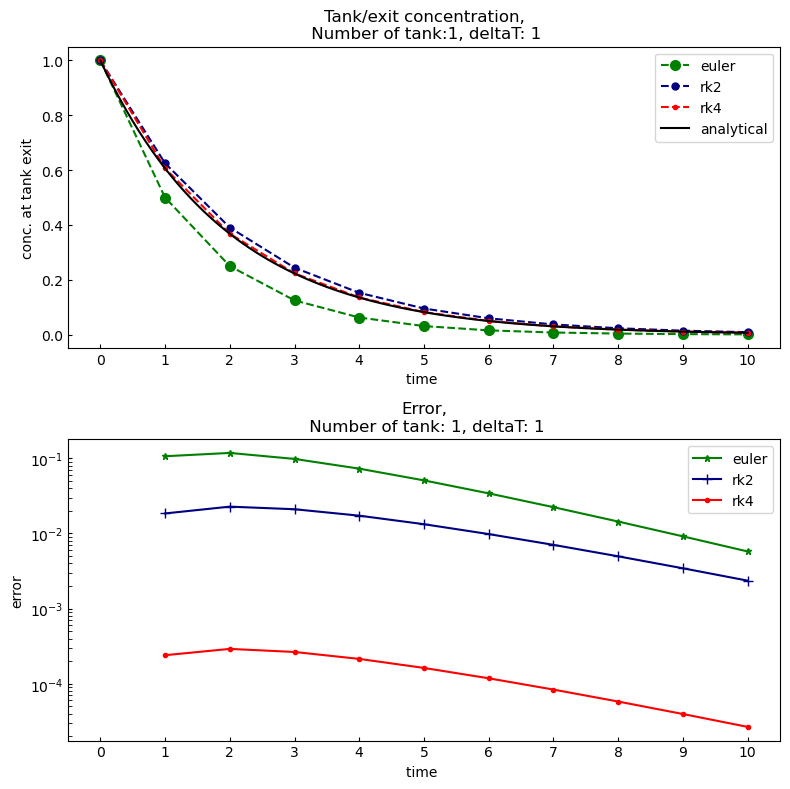

In [6]:
method_comparision(tau=2, N=1, dt=1, Tmax=10, c_init='first')

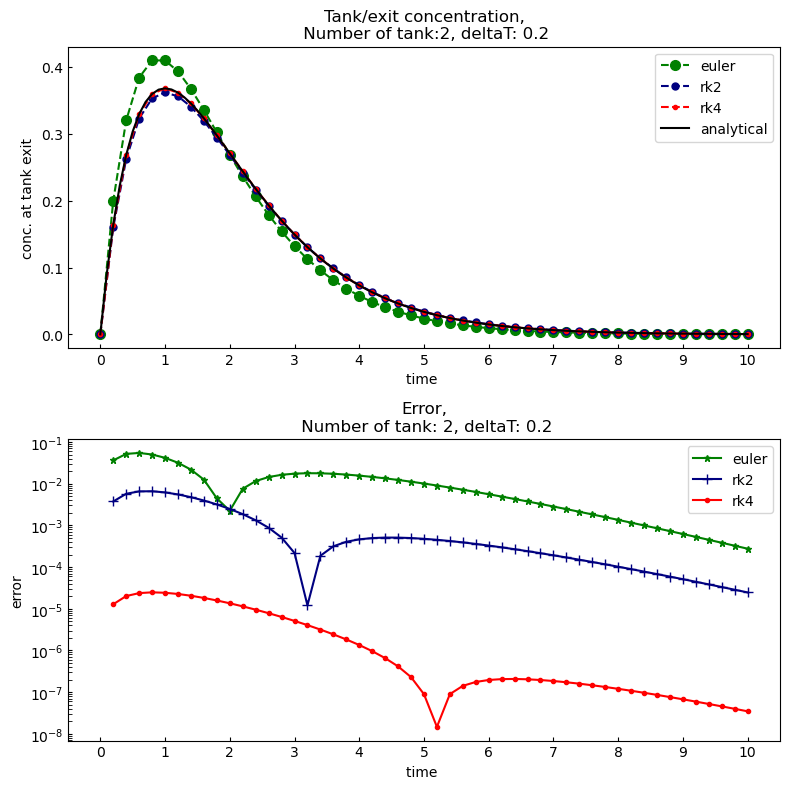

In [7]:
method_comparision(tau=2, N=2, dt=0.2, Tmax=10, c_init='first')

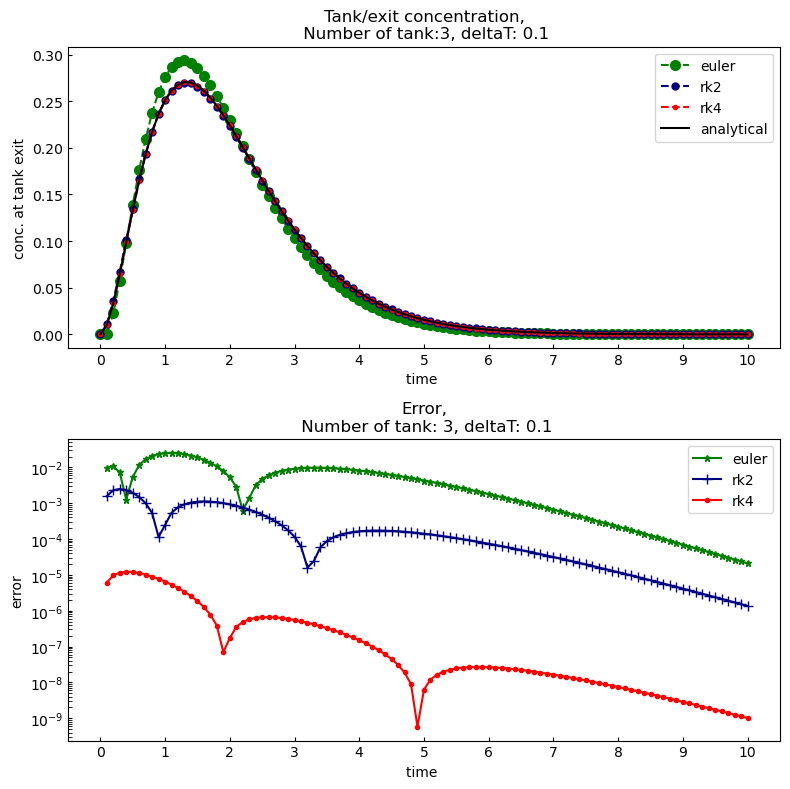

In [8]:
method_comparision(tau=2, N=3, dt=0.1, Tmax=10, c_init='first')

**Discussion of the plots:**

The implementation is tested against the analytical solutions for all three setup with 1 to 3 tanks. We use varying values of $\Delta t$ depending on the number of tanks being simulated to highlight the accuracy of each of the solvers. The plots confirm our theoretical understanding of the errors produced when using the three methods, i.e. Euler method is the least accurate solution and RK4 is the most accurate.  The implementation is plotted against analytical solutions for all three setups, involving 1 to 3 tanks. Furthermore, the error for each method is graphically depicted, revealing the evolution of error at each time step.

It is interesting to see how the error changes as the simulation progresses. Taking the Euler solution as an example: the change in analytical solution's curvature (second derivative) affects the error values. The error increases while the curvature is increasing and reduces when the curvature approaches 0. It is also interesting to note that the 'dips' in the error plot occurs when the numerical solution 'crosses' the analytical solution. It can be clearly seen for Euler solution plot for the case with 3 tanks that the error in the $c_{out}$ occurs when green line(Euler soln) crosses the black line(analytical soln.) at  around 0.4s and at 2.2s in the simulation. These are also the inflection points in the analytical solution, i.e. the curvature changes sign. Similarly the dips in the error plots for RK2 and RK4 can be shown to occur at the inflection point of the third and the fifth order derivatives of the analytical solution. This is in line with our understanding of the *local truncation error*. 


**Part 3**.
 Pick $n =1, 2, or 3 $
 
1. plot the numerical error at t = 1, for the last tank, and for dt values in
the range $0.1, . . . 0.001$. (You may try lower values if you have a very fast
solver)
2. does the numerical error scale as expected for Euler, RK2, and RK4?

Δt =  [1.e-01 1.e-02 1.e-03 1.e-04 1.e-05]


/tmp/ipykernel_204/578809048.py:35: RuntimeWarning: divide by zero encountered in log
  err_slope.append(np.log(error))



Tanks: 1     
order of method trunc. errors [euler, RK2, RK4]:
 [[1.         1.         1.         1.         1.        ]
 [1.84135199 1.89055721 1.91698942 1.93318587 1.94462895]
 [3.69185486 3.78308959        inf 2.88082427 2.34689071]]

Tanks: 2     
order of method trunc. errors [euler, RK2, RK4]:
 [[1.         1.         1.         1.         1.        ]
 [1.6745103  1.7954312  1.85027995 1.88190149 1.90247765]
 [3.43243213 3.62520411 3.72661185 3.11500274 2.45641004]]

Tanks: 3     
order of method trunc. errors [euler, RK2, RK4]:
 [[1.         1.         1.         1.         1.        ]
 [2.25000203 2.01366488 2.0036088  2.00235565 2.00196662]
 [3.23266691 3.49768544 3.63423944 3.33960453 2.72353652]]


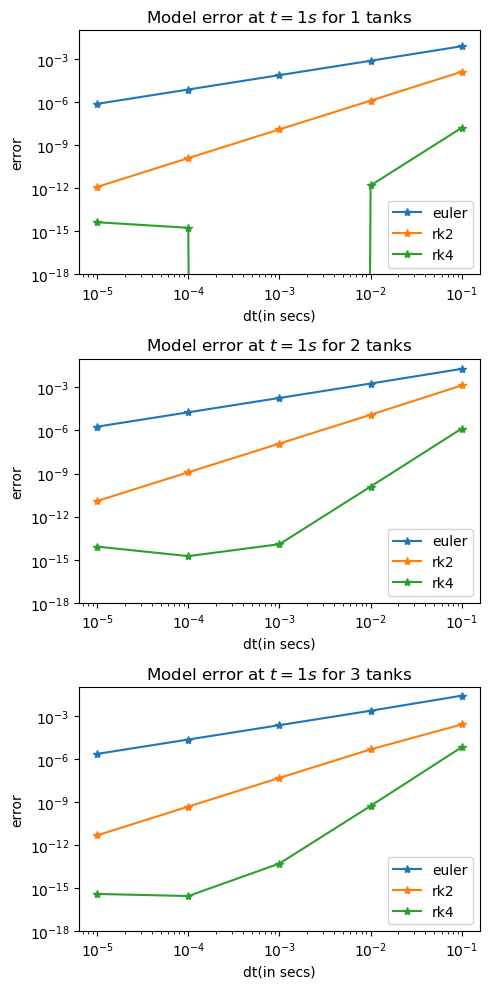

In [9]:
# parameters. do this for finer dt scaling
n = 5 # used to calculated 10**-n
tau = 2
Tmax = 1 # time at which the error is calculated
c_init = 'first'  # initial concs in the tanks

# make the figure
fig, axs = plt.subplots(nrows = 3, figsize=(5,10))

# time deltas
dts = np.geomspace(.1, 10**-n, n)
print('Δt = ',dts)


#print('Normalized slope of the error wrt Δt: (normalized to Eulers, in log scale)')
for N, ax in zip([1,2,3], axs): 
    err_slope =[]
    for method in ['euler', 'rk2', 'rk4']:
        error = []
        for dt in dts:
            # make model
            timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
            model = CSTRModel(tau=tau, N=N, timedata=timedata, c_init=c_init)
            
            # find numerical solution to and keep only the result at t= Tmax
            soln =model.time_sim(N=N, tau=tau, c_init=c_init, ODEmethod=method)[-1]
            
            # find solution to and keep only the result at t= Tmax
            analytical = model.analytical()[-1]
            
            # find error
            error.append(np.abs(soln-analytical))
        #err_slope.append(np.log10((error[-1]-error[0])/(dts[-1]-dts[0])))
        ax.plot(dts, error,'-*' ,label=method)
        err_slope.append(np.log(error))

        # print(method,error)
    err_slope = np.array(err_slope)/err_slope[0]
    print()
    print(f'Tanks: {N}', '    \norder of method trunc. errors [euler, RK2, RK4]:\n', err_slope)
    ax.set(xlabel='dt(in secs)', ylabel='error',
           title=f'Model error at $t=1s$ for {N} tanks',
           ylim=(10**-18,0.1),xscale='log', yscale='log')
    ax.legend()
plt.tight_layout()

**Discussion of the plots:** 

In this exercise we are handling the *total accumulated error* over the time domain simulations. The accumulated error scale of the numerical methods are as following:
- Euler method   : $O(dt)$
- Second-Order RK: $O(dt^2)$
- Forth-order RK : $O(dt^4)$

From plot it is clear that as $\Delta t$ decreases by a factor of 10, the error produced by Euler method decreases by a factor of 10, the error produced by RK2 method decreases by a factor of $10^2$ and error produced by RK4 decreases by a factor of $10^4$. This is evident by the steepness of the error vs $\Delta t$ curve in the figures above. 

Initially, for RK4 method, the errors scale very well with decreasing $\Delta t$, and the error decreases to a level of about $10^{-16}$ for $\Delta t = 10^{-3}$. However, beyond this point for RK4 method, the effect of rounding errors becomes significant, and the error tends to stay around the level of the machine epsilon, which is approximately $10^{-16}$.
In the provided plots, it's evident that the error for the fourth-order Runge-Kutta (RK4) method reaches the level of $10^{-16}$. The complexity of the solution plays a crucial role in error behavior. More complex solutions exhibit higher curvature in the analytical solution, resulting in higher errors in the numerical solution. Consequently, in the three plots, the solution with one tank, being the simplest, shows lower numerical solution errors. As the time step (dt) decreases, the error reaches the $10^{-16}$ level faster, but the influence of rounding errors becomes apparent earlier.

From the above plots it can be concluded that the *optimal* $\Delta t$ for RK4 method is around $10^{-3}$. The other two methods, require a lot smaller $\Delta t$ to reach the same level of numerical error.  

It appears that something unusual is happening with the error behavior of the fourth-order Runge-Kutta (RK4) method in the problem with one tank. To investigate this, we conducted a detailed analysis by plotting the error for all time points of the RK4 solution across various time step values, including [0.1, 0.01, 0.001, 0.0001].

In [10]:
def error_comparision1(tau=2, N=1,dt=3,Tmax=20,c_init='first'):
    timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
    model = CSTRModel(tau=tau, N=N, timedata=timedata, c_init=c_init)
    #nparams = model.nparams#

    soln=model.time_sim(N=N, tau=tau, c_init=c_init, ODEmethod='rk4')
    
    #print(soln1,soln2,soln3)
    analytical = model.analytical()
    ts, tsa = model.ts, model.tsa
    return ts, soln, analytical
    # comparision_plot(N, dt, ts, tsa, analytical, *soln)

In [11]:
N = 1
time1, soln1, an1 = error_comparision1(tau=2, N=N, dt=0.1, Tmax=8, c_init='first')
time2, soln2, an2 = error_comparision1(tau=2, N=N, dt=0.01, Tmax=8, c_init='first')
time3, soln3, an3 = error_comparision1(tau=2, N=N, dt=0.001, Tmax=8, c_init='first')
time4, soln4, an4 = error_comparision1(tau=2, N=N, dt=0.0001, Tmax=8, c_init='first')

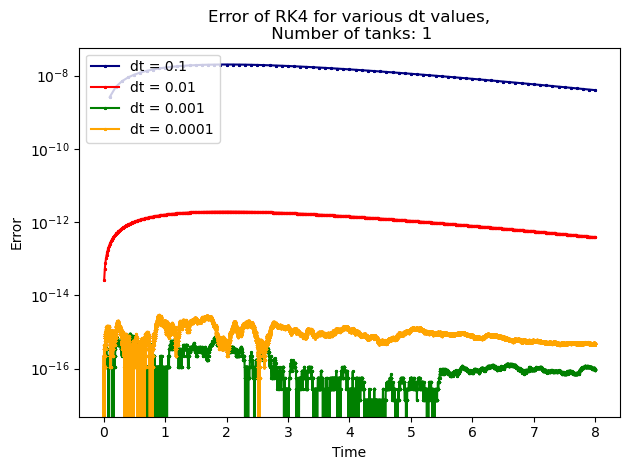

In [12]:
len(soln1)
len(an1)
plt.plot(time1[1:], np.abs(soln1[1:]-an1[1:]), '-*', markersize=2, label='dt = 0.1', color='navy')
plt.plot(time2[1:], np.abs(soln2[1:]-an2[1:]), '-*', markersize=2, label='dt = 0.01', color='red')
plt.plot(time3[1:], np.abs(soln3[1:]-an3[1:]), '-*', markersize=2, label='dt = 0.001', color='green')
plt.plot(time4[1:], np.abs(soln4[1:]-an4[1:]), '-*', markersize=2, label='dt = 0.0001', color='orange')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title(f'Error of RK4 for various dt values,\n Number of tanks: {N}')
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

It is clear that when the time step $\Delta t$ is set to 0.001, the error produced by RK4 is same as the machine epsilon($10^{-16}$). At this  point the error is indistinguishable from $0$ and thus the plotted error for one tank solution shows up as 0 in the previous figure. It is interesting to note that the error produced when $\Delta t$ is set to 0.0001 is higher, and this is dominated by round off error(as opposed to truncation error)

### Exercise 2: Fit CSTR model to CFD model: Healthy aorta

Steward-Hamilton equation [6]:

$$ q = \frac{M_{inj}}{\int_{0}^{\infty}C_{out}(t)dt}$$



**Part 1**.
1. Use $M_{inj}$ = 83.333 gram, equation (7) and the data in Healthy_rect_1s.csv
to show that q = 5 L/min.

only the injected mass tracer $M_{inj}$ is known. For the CFD simulations, $M_{inj} = 83.33$ grams is used. By knowing the mass of the injected tracer, and the outlet concentration, then we can calculate the volumetric injection flow rate $q$.

In [13]:
concdata = pd.read_csv('data/Healthy_rect_1s.csv')
dt = concdata.Time[1]-concdata.Time[0] # in seconds
dt =dt/60  # convert to mins
Minj = 83.333 #in grams

# we could have used the trapizoidal integration here. 
# but just summing the concentrations over time works too 
# and the difference from trapizoidal method is insignificant 
#q = Minj/np.trapz(concdata.Concentration)/dt   
q = Minj/concdata.Concentration.sum()/dt   

(f'Flow rate from healthy heart data: {q:0.2f} ml/min or {q/1000:0.2f} L/min')

'Flow rate from healthy heart data: 5005.98 ml/min or 5.01 L/min'

**Part 2**. Make Python functions that reproduces at least three other injection protocol than rect_1s (i.e. minimum four in total) from figure 5, as an
inspiration you can use the code below for the rect_1s

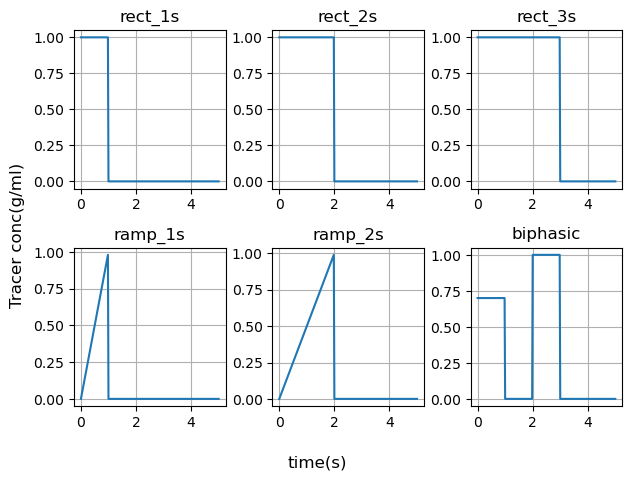

In [14]:
protocols = ['rect_1s', 'rect_2s', 'rect_3s', 'ramp_1s', 'ramp_2s', 'biphasic']
t = concdata.Time.to_numpy()
Tmax = t.max()
dt = 0.02
fig, axs = plt.subplots(nrows = 2, ncols = 3)
axs = axs.flatten()
for ax, protocol in zip(axs, protocols):
    #timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
    model = CSTRModel(timedata=t, inj_prot=protocol)
    c = model.cinj(t)  # injection concentrations
    ax.plot(t,c)
    ax.grid()
    ax.set_title(protocol)
fig.supylabel('Tracer conc(g/ml)')
fig.supxlabel('time(s)')
plt.tight_layout()

The protocols are defined in the function `make_injection_protocol()` in the python class `CSTRModel`. The codes above extracts the injection protocols from the class and plots them.

**Part 3**.
- For the 1s rectangular pulse injection protocol, tune $\tau = Vtot/q$ and the number of compartments to match the data for the healthy patient (Healthy_rect_1s.csv) .
- Make a figure where you show your "best match". Use scatter points for the data, and solid lines for your simulation.
- "Best match" of VTot can be done by one of the following methods, there will be an increasing number of points given if you choose the most difficult
method
1. (easy) manually adjust V to match data
2. (moderate) use scipy.optimize.curve_fit to find V
3. (hard) In the course we have covered several algorithms that are useful for finding roots and/or minima of functions, e.g., fixed point iteration,
Newton’s Raphson’s method, the bisection method, the secant method, and gradient descent. Implement one of these methods, and use it to find the $\tau$ -value that minimizes SSR (see Appendix A). Hint: Depending on the method(s) you choose, you may have to implement a Python function to calculate the second derivative of C2 with respect to $\tau$.

In [15]:
def load_CFD_data(healthy=True, protocol = 'rect_1s'):
    '''
    Loads theCFD data to a dataframe
    '''
    if healthy: h = 'Healthy'
    else: h = 'Aneurysm'
        
    datafile = f'data/{h}_{protocol}.csv'
    print(datafile)
    concdata = pd.read_csv(datafile)
    t = concdata.Time.to_numpy()
    conc_CFD = concdata.Concentration.to_numpy()
    return(t,conc_CFD)

In [16]:
def plot_SSR_Surface(t,conc_CFD,taus=np.arange(2.,3.,0.1),Ns= np.arange(45,53,1),\
                      levels = np.arange(0,1,0.1)):
    x = taus # tau
    y =  Ns # N
    #t,conc_CFD=load_CFD_data(healthy=healthy, protocol=protocol)
    print(f'N:{len(y)}  taus:{len(x)}')
    X,Y = np.meshgrid(x, y) # grid of point
    Z=[]
    for x,y in (zip(X,Y)):
        z=[]
        for tau,N in (zip(x,y)):
            #print(_)
            z.append(SSR(tau= tau,N=N,xdata=t, ydata = conc_CFD))
        Z.append(z)
    Z=np.array(Z)
    idx=np.where(Z==Z.min())
    print(f'min error: {Z.min()}')
    print(f'parameters: {X[idx]}{Y[idx]}')

    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(projection = '3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                          cmap=cm.RdBu,linewidth=0, antialiased=False)
    ax.set()

    #ax.zaxis.set_major_locator(LinearLocator(10))
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    
    plt.figure()
    cset = plt.contour(X,Y,Z,levels = levels, linewidths=2,cmap=cm.Set2)
    #cset=contour(X,Y,Z)
    plt.clabel(cset,inline=True,fmt='%.5f',fontsize=10)
    plt.scatter(X[idx],Y[idx], label='minima')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    #colorbar(im) # adding the colobar on the right
    plt.title('Contour')
    a = plt.legend()

In [17]:
class Minimizer():
    '''
    provides various minimization tools
    '''
    def __init__(self, prec=1e-8,MAXIT=10):
        self.prec=prec
        self.MAXIT=MAXIT
        
    def gradient(self, f,x, dx=10e-4,**kwarg):
        '''
        takes a function f and returns its gradient(df/dx) at x
        using central difference, 
        '''
        return (f(x+dx,**kwarg)-f(x-dx,**kwarg))/2/dx
    
    def curvature(self, f,x,dx=10e-4,**kwarg):
        '''
        takes a function f and returns its curvature (d**2f/dx**2) at x
        using central difference, 
        '''
        curvature = (f(x+dx,**kwarg)-2*f(x,**kwarg)+f(x-dx, **kwarg))/2/dx
        
    def gradient_descent(self, f,x,df, g=.001, **kwarg):
        '''Minimize f(x) by gradient descent.
        f   : min(f(x))
        x   : starting point 
        df  : derivative of f(x)
        g   : learning rate
        prec: desired precision

        Returns x when it is closer than eps to the root, 
        unless MAXIT are not exceeded
        '''
        x_old = x
        df_old=df(f,x_old,**kwarg)
        for n in range(self.MAXIT):
            #plot_regression_line(x_old)  
            x_new = x_old - g*df_old
            if(np.max(np.abs(x_new-x_old))<self.prec):
                print('Found solution:', x_new, 
                      ', after:', n, 'iterations.' )
                return x_new
            x_old=x_new
            df_old=df(f,x_old,**kwarg)

        print('Max number of iterations: ', self.MAXIT, ' reached.') 
        print('Try to increase MAXIT or decrease prec')
        print('Returning best guess, value of function is: ', x_guess:=f(x_new))
        return x_new,np.array(x_guess)

    def Jacobian(self,f,x,dx=1e-5,**kwarg):
        N=len(x)
        f0=f(x,**kwarg)
        #print('in jacobian f0=f(x,**kwarg)')
        J=np.zeros(shape=(N,N))
        #print(J,f0)
        for j in range(N):
            x[j] = x[j] +  dx
            fx=f(x,**kwarg)
            for i in range(N):   
                J[i][j] = (fx[i]-f0[i])/dx
                #print(f'assigning J{i},{j}')
            x[j] = x[j] -  dx
        return J

    def newton_raphson(self, f,x,J=None, jacobian=False,**kwarg):
        '''Approximate solution of f(x)=0 by Newtons method.
        The derivative of the function is calculated numerically
        f   : f(x)=0. this is the derivative
        J   : Jacobian
        x   : starting point  
        eps : desired precision

        Returns x when it is closer than eps to the root, 
        unless MAX_ITERATIONS are not exceeded
        '''
        MAX_ITERATIONS=self.MAXIT
        #x=args
        self.n_iter = 0 
        x_old = np.copy(x)
        for n in range(MAX_ITERATIONS):
            #plot_regression_line(x_old) 
            self.n_iter = n
            if not jacobian:
                #print('call Jac with',x_old)
                J_=self.Jacobian(f,x_old,**kwarg)
            else:
                J_=J(x_old)
            z=np.linalg.solve(J_,-f(x_old,**kwarg))
            x_new=x_old+z
            if(np.sum(abs(x_new-x_old))<self.prec):
                #print('Found solution:', x_new, 
                #      ', after:', n, 'iterations.' )
                return x_new
            x_old=np.copy(x_new)
        print('Max number of iterations: ', self.MAXIT, ' reached.') 
        print('Try to increase MAXIT or decrease prec')
        print('Returning best guess, value of function is: ', f(x_new))
        return x_new

In [18]:
def SSR(tau, xdata=[], ydata=[], N=1, inj_prot=protocol):
    '''
    Returns the sum of squared residuals
    params:
        N, tau and inj_prot(injection protocol) : model parameters
        xdata is the time data
        ydata is the curve we need to fit to
    returns the SSR
    '''
    timedata = xdata
    conc_CFD = ydata
    model = CSTRModel(tau=tau, N=N, timedata=timedata, inj_prot=inj_prot)
    conc_out = model.time_sim(N, tau)
    #print (f'conc_CFD: {len(conc_CFD)}, conc_out: {len(conc_out)}')
    SSR = np.sum((conc_CFD-conc_out)**2)
    return SSR

def dSSR(tau,**kwarg):
    '''
    returns the slope of the SSR function at the tau using 
    central diff from our minimizer
    params:
        tau : model parameter (residence time)
    returns 
        slope of SSR
    '''
    a = Minimizer()
    gradient = a.gradient
    return (np.array([gradient(SSR, tau,**kwarg)]))

def ddSSR(tau,**kwarg):
    '''
    returns the curvature of the SSR function at the tau using 
    central diff from our minimizer
    params:
        tau : model parameter (residence time)
    returns 
        curvature of SSR at tau
    '''
    a = Minimizer()
    gradient = a.gradient
    return (np.array([gradient(dSSR, tau,**kwarg)]))

In [19]:
def fit_CFD_data(healthy=True, protocol='rect_1s', Ns=range(47, 52), solver='NR', ax=None):
    '''
    does the following things:
       1. reads CFD simulated data
       2. cycles through various number of tanks and finds optimal 
          tau at each N. 
       3. plots the 
    '''

    t, conc_CFD = load_CFD_data(healthy, protocol)  # reads CFD data
    leastSSR = 200_000  # set value of SSR to some ridiculous value
    m = Minimizer()

    for N in Ns:
        params = {'xdata': t, 'ydata': conc_CFD, 'N': N, 'inj_prot': protocol}
        tau = 2.  # first guess
        if solver == 'graddesc':
            tau_ = m.gradient_descent(
                f=SSR, x=tau, df=dSSR, MAXIT=10000, **params)
        else:
            # newton raphson implimentation takes a list and returns a list
            # so the input requires to be sent as a list.
            tau_ = m.newton_raphson(
                x=[tau], f=dSSR, jacobian=False, **params)[0]
        ssr = SSR(tau=tau_, **params)
        if ssr < leastSSR:
            optimal_N = N
            optimal_tau = tau_
            print(f'new optimal tau found {optimal_tau:0.4f}s, >N= {optimal_N}, SSR: {ssr}')
            leastSSR = ssr
        '''
        #uncomment this part if you want the loop to stop once SSR starts incereasing with N
        else:
            print(
                f'Minima found at N={optimal_N} tanks and τ ={optimal_tau:.4f},',
                f' using {solver} in {m.n_iter} iterations(avg)')
            print('-'*80)
            break
        '''    
    print(f'Minima found at N={optimal_N} tanks and τ ={optimal_tau:.4f},',
                f' using {solver} in {m.n_iter} iterations(avg)')
    print('-'*80)
    
    tau = optimal_tau
    N = optimal_N
    model = CSTRModel(tau=tau, N=N, timedata=t, inj_prot=protocol)
    #conc_model_manual = model.time_sim(N, tau)
    conc_model_fitted = model.time_sim(N, tau)
    injection = model.cinj(t)

    #fig, ax = plt.subplots()
    #ax.plot(t, conc_model_manual,'*', markersize=2 ,label = 'numerical manual')
    ax.plot(model.ts, conc_model_fitted, 'o', color ='b',
            markersize=1, label='numerical'+solver,)
    ax.plot(model.ts, injection, '--', markersize=2,
            label='injection', alpha=0.5, lw=1)
    ax.plot(t, conc_CFD, label='CFD', color= 'r')
    

    ax.set_title(f'{optimal_N} tanks, τ = {optimal_tau:.4f}s\n'+ f'{protocol}')
    # ax.legend()

    return(optimal_N, optimal_tau)

To fit our model to the CFD results provided we have written the following functions:
1. function `load_CFD_data` : read the CFD data
2. class `Minimizer` : to perform regression analysis
3. function `SSR` : to calculate the difference between our numerical value and the CFD results
4. function `dSSR` : the derivative of the SSR function wrt to $\tau$, since we want to find the optimal $\tau$
5. function `fit_CFD_data` : to perfom the optimization of $\tau$ by changing the number of tanks, thus finding the optimal combination of N and $\tau$ such that SSR is minimum. 


data/Healthy_rect_1s.csv
new optimal tau found 2.3800s, >N= 20, SSR: 1.7231231929267872
new optimal tau found 2.3789s, >N= 21, SSR: 1.5321371259953376
new optimal tau found 2.3779s, >N= 22, SSR: 1.3610990232051872
new optimal tau found 2.3770s, >N= 23, SSR: 1.207795576767563
new optimal tau found 2.3762s, >N= 24, SSR: 1.0703054034927422
new optimal tau found 2.3755s, >N= 25, SSR: 0.9469534341856483
new optimal tau found 2.3748s, >N= 26, SSR: 0.8362735864325856
new optimal tau found 2.3742s, >N= 27, SSR: 0.7369780084934434
new optimal tau found 2.3737s, >N= 28, SSR: 0.6479315774815936
new optimal tau found 2.3732s, >N= 29, SSR: 0.5681306299289137
new optimal tau found 2.3727s, >N= 30, SSR: 0.4966851250315238
new optimal tau found 2.3723s, >N= 31, SSR: 0.43280360986651795
new optimal tau found 2.3719s, >N= 32, SSR: 0.37578048552396864
new optimal tau found 2.3715s, >N= 33, SSR: 0.324985173379149
new optimal tau found 2.3711s, >N= 34, SSR: 0.2798528588814395
new optimal tau found 2.3707s,

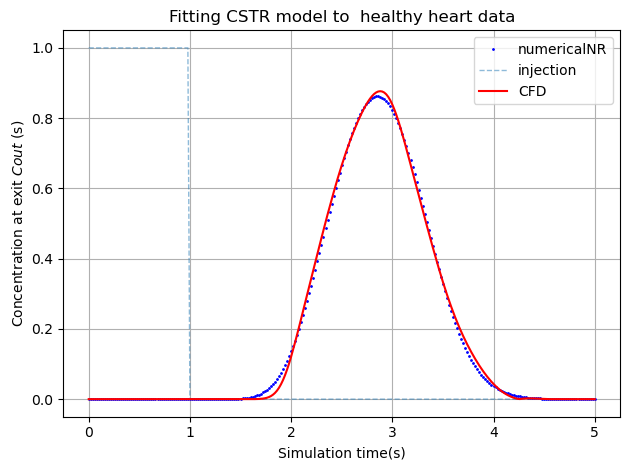

In [20]:
protocol = 'rect_1s'
fig, ax = plt.subplots()
optimal_N_re1s, optimal_tau_re1s = fit_CFD_data(
    healthy=True, protocol=protocol, Ns=range(20, 60), solver='NR', ax=ax)

ax.set_title(f'Fitting CSTR model to  healthy heart data')
ax.set_xlabel(f'Simulation time(s)')
ax.set_ylabel(f'Concentration at exit $Cout$ (s)')
#handles = ax.get_legend_handles_labels()
ax.legend()  # (*handles,loc='lower right', ncol=5)
plt.grid()
plt.tight_layout()

The above plots compare the responses simulated with fitted parameters roe every injection protocol to the CFD data for healthy one. From theory, we know that $\tau=V_{total}/q$. It follows that $V_{total}=q*\tau$. The volume of the aorta can thus be calculated as shown below.

In [21]:
print(f'Flowrate, q = {q:0.2f} ml/min, Optimal τ ={optimal_tau_re1s:.2f}s')
print(f'The total volume of the healthy aorta is {q/60*optimal_tau_re1s:0.2f}mL')

Flowrate, q = 5005.98 ml/min, Optimal τ =2.37s
The total volume of the healthy aorta is 197.49mL


**Part 3 discussion:**

We chose to solve the minimization problem using the hard way (although we have also tried fitting the model by hand and using `scipy.optimize.curve_fit`, but they have not been shown). We tried modelled both *gradient descent* and *Newton Raphson's* methods. Both of the algorithms give similar results but Newton Raphson’s method is much faster at finding the optimal solution. We therefore chose to only present the results from the Newton Raphson's method in this assignment.     

data/Healthy_rect_1s.csv
data/Healthy_rect_2s.csv
data/Healthy_rect_3s.csv
data/Healthy_ramp_1s.csv
data/Healthy_ramp_2s.csv
data/Healthy_biphasic.csv


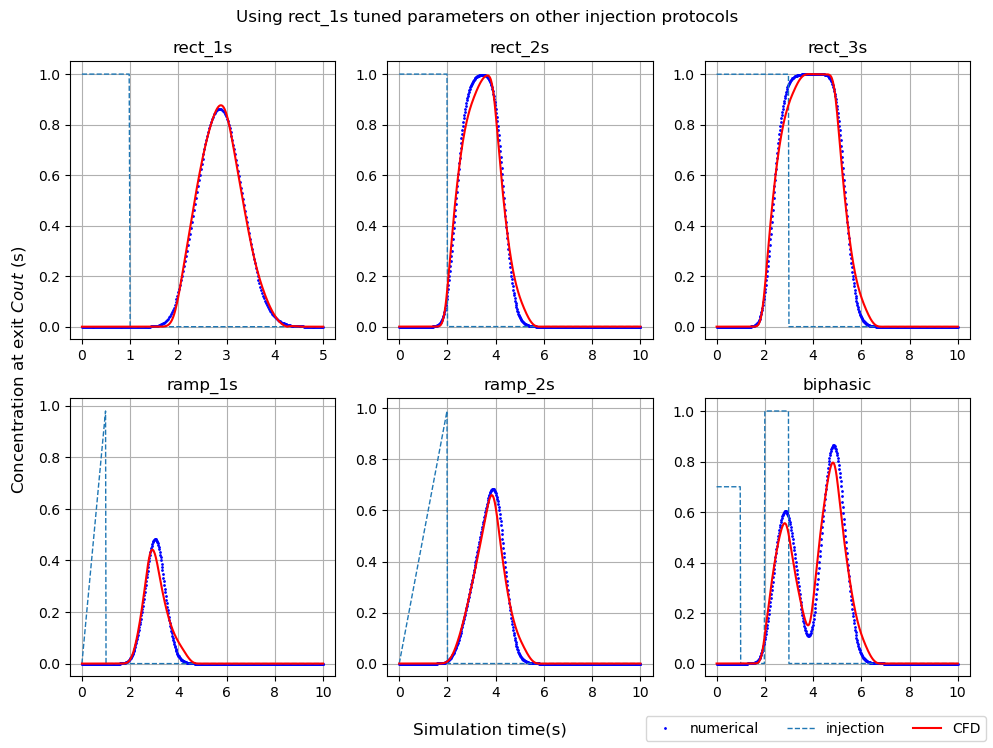

In [22]:
N = optimal_N_re1s
tau = optimal_tau_re1s

protocols = [f'rect_{i}s' for i in [1, 2, 3]] +\
            [f'ramp_{i}s' for i in [1, 2]] +\
            [f'biphasic']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7.5))
axs = np.ndarray.flatten(axs)

for ax, protocol in zip(axs, protocols):
    t, conc_CFD = load_CFD_data(protocol=protocol)
    model = CSTRModel(timedata=t, inj_prot=protocol)
    y = model.time_sim(N=N, tau=tau)
    injection = model.cinj(t)
    
    ax.plot(model.ts, y, 'o', color ='b',
            markersize=1, label='numerical')
    ax.plot(model.ts, injection, '--', markersize=2,
            label='injection', lw=1)
    ax.plot(t, conc_CFD, label='CFD', color= 'r')
    ax.set_title(protocol)
    ax.grid()
fig.suptitle(f'Using rect_1s tuned parameters on other injection protocols ')
fig.supxlabel(f'Simulation time(s)')
fig.supylabel(f'Concentration at exit $Cout$ (s)')
handles = ax.get_legend_handles_labels()
fig.legend(*handles,loc='lower right', ncol=5)
plt.tight_layout()



**Part 4 discussion**

As suggested in the problem statement we keep the value of the residence time $\tau$ and the number of compartments N, the same as we found for the 1s rectangular signal and use it to predict the results for the other injection protocols. We have chosen to show the results for all the protocols for which data was supplied.  

findings:
1. for rectangular injection protocols the CFD data lags behind what our models predict. The peak of the $c_{out}$ signal is however at the same level for both our model and the CFD data. 
2. for ramped injection protocols our model lags behind the CFD data output. In this case the peak of the CFD data is also lower than what our model predicts. This can be explained by the fact that the tracer remains longer inside the aorta before being flushed out in the CFD model.   
3. for biphasic injection protocol our models fit is even worse. The behaviour model is close to the ramp injection protocols, showing higher peaks and lower troughs and the peak of the tracer concentration lags that of the CFD results. Physically it means that in the CFD model the tracer stays in the aorta for longer and is released slower at the exit of the aorta.  

We performed a check of the optimal values of the parameters N and $\tau$ for the other protocols. The values for the optimal $\tau$ are pretty close to the one we found for `rect_1s` but widely different values for optimal value of N. The figure below shows the values of N for which the SSR is minimum. For all injection protocols other than `rect_1s` the optimal value of N is around 32 tanks.

One possible explanation of the lag in the $c_{out}$ could be that in the CFD model the fluid is allowed to flow in all the three dimensions whereas a mixing tank homogenizes the concentration of the tracer throughout the volume of the tank. This is why the our model flushes our the tracer much quicker than the CFD model where the tracer is allowed to diffuse radially out over time as can be seen in the figure below.

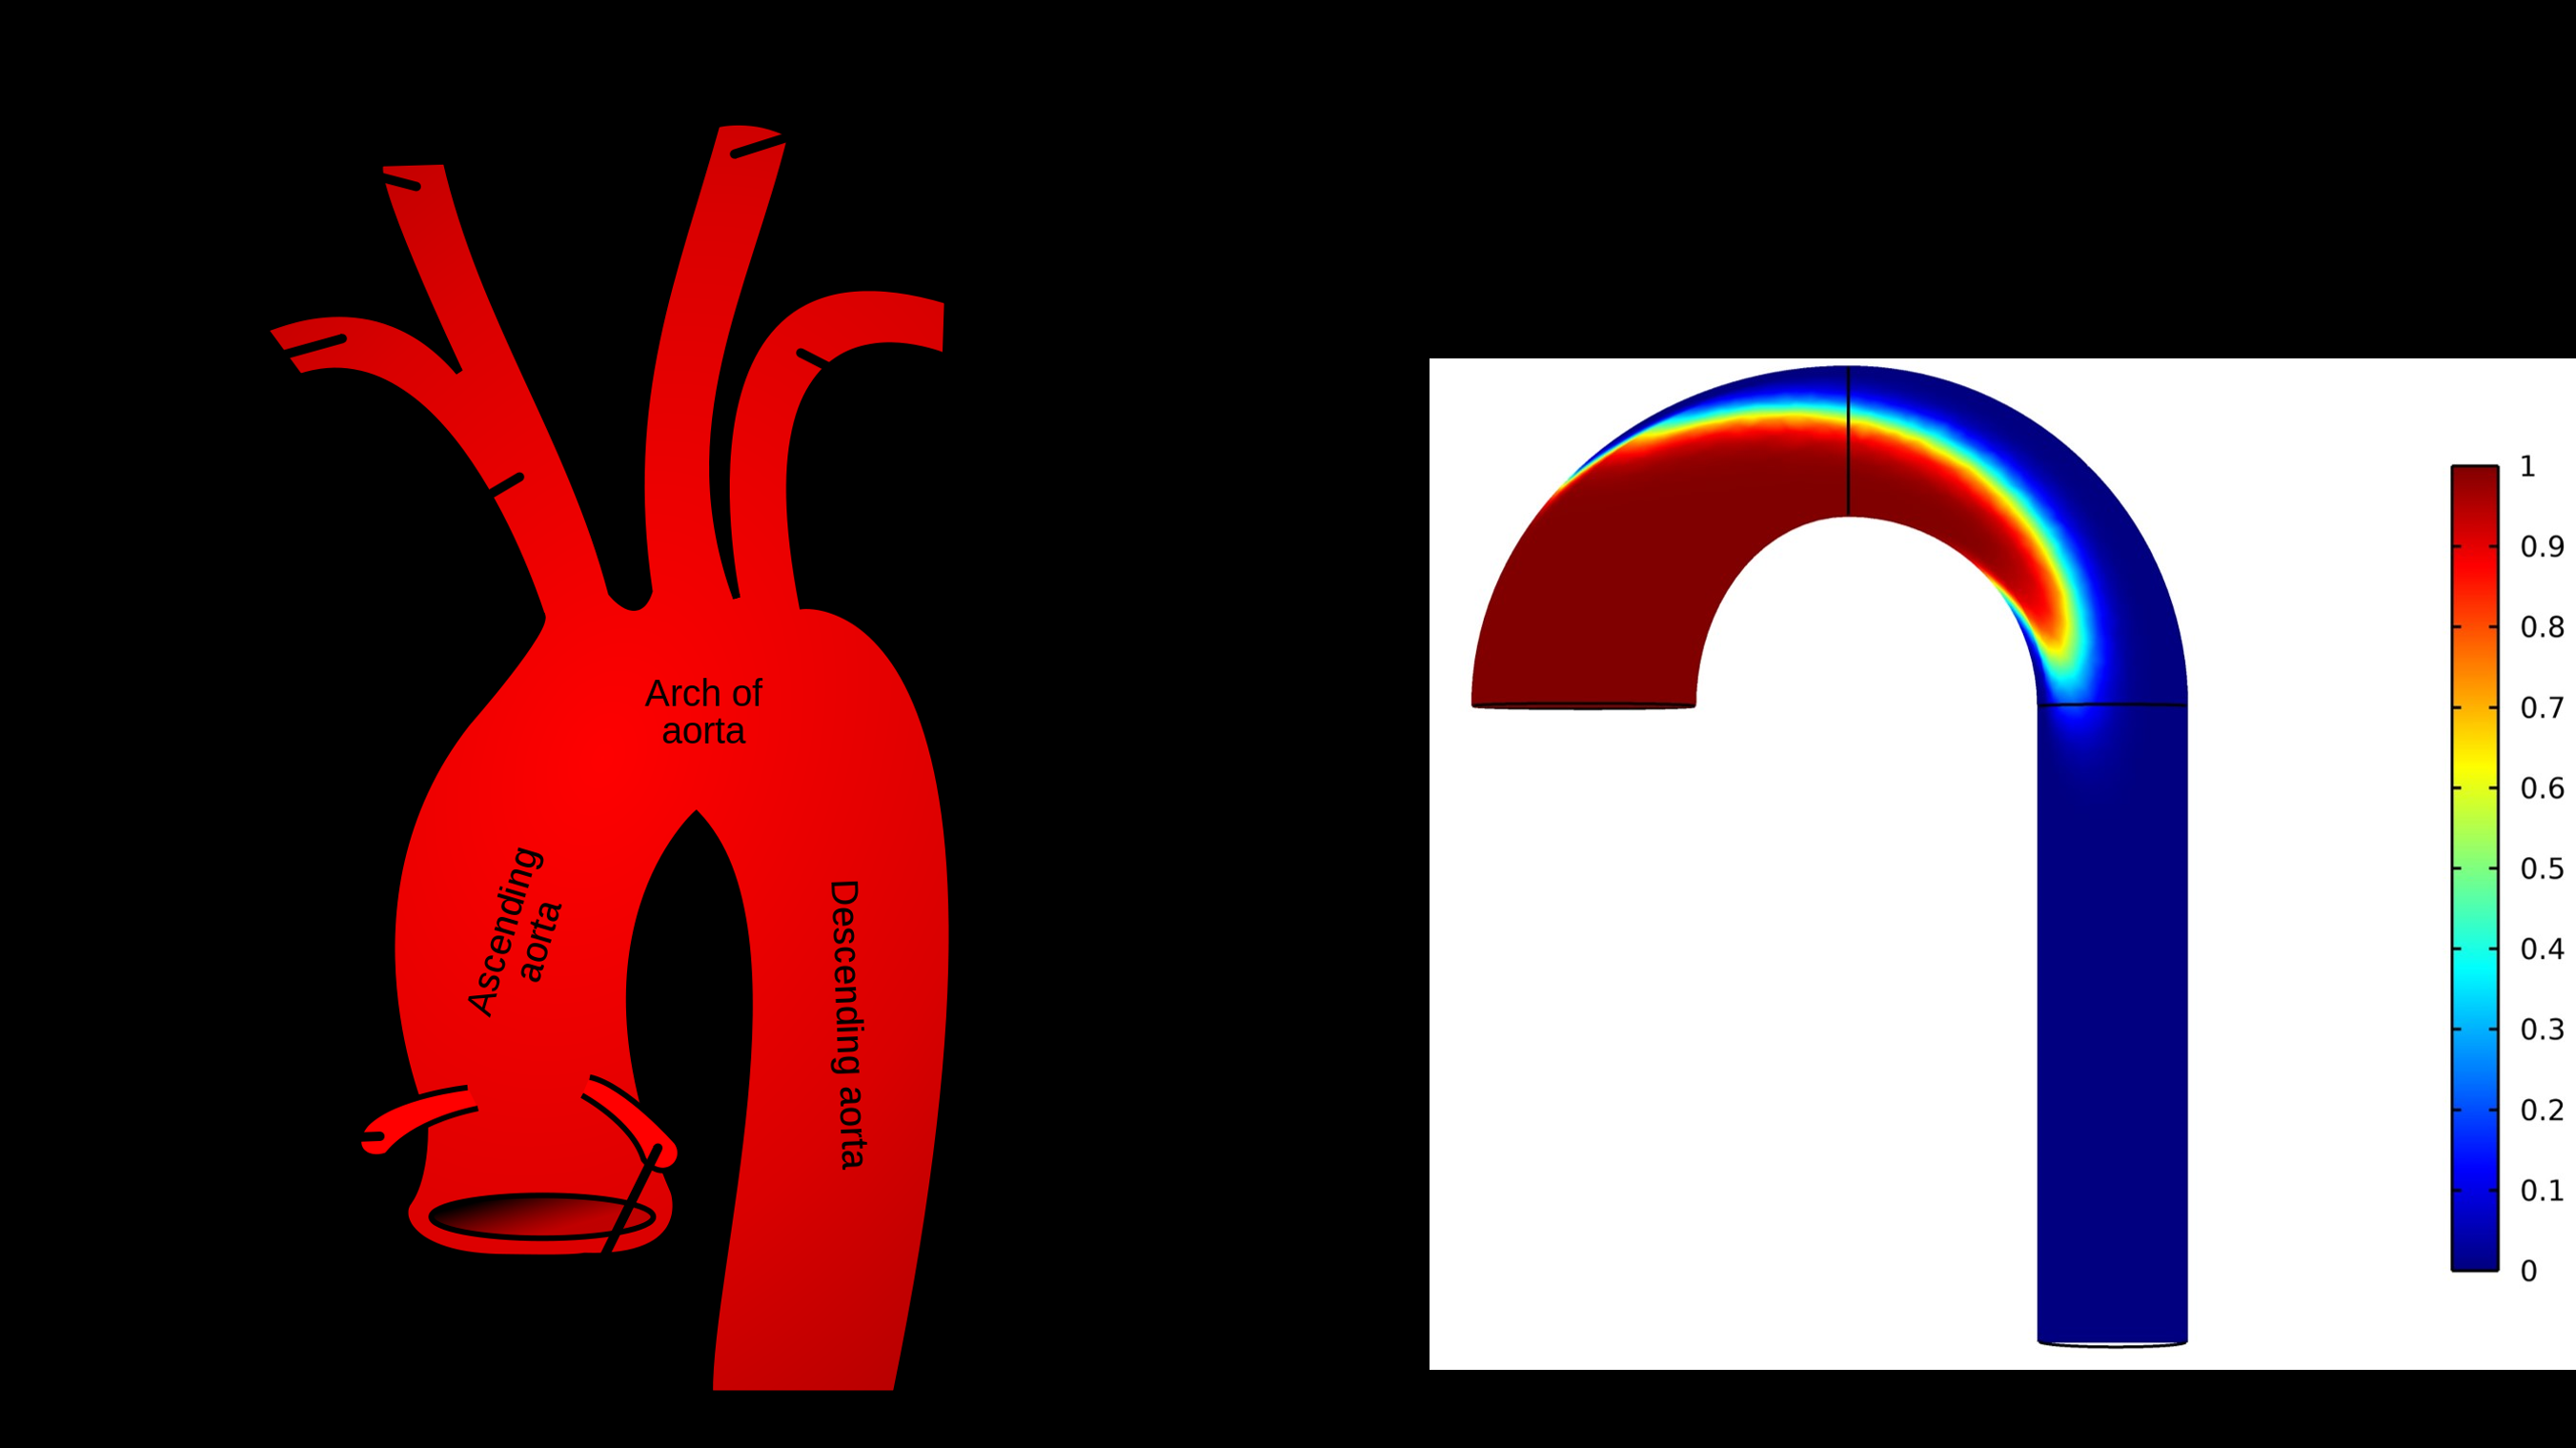

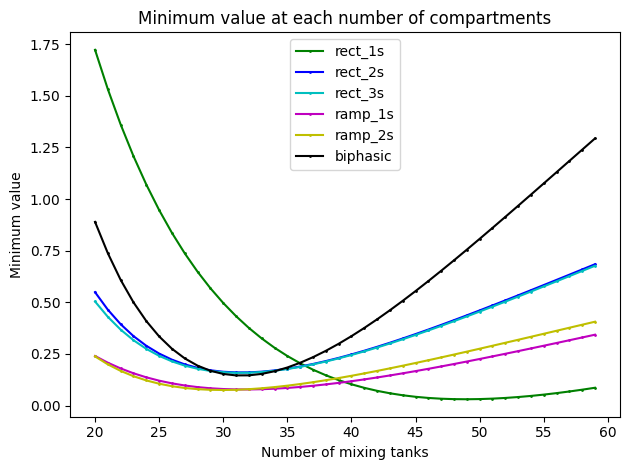

This  would suggest that in order to capture the changing slope of the concentration plot we need to decrease the number of tanks and using the parameters found from fitting the `rect_1s` data is not the best fit.

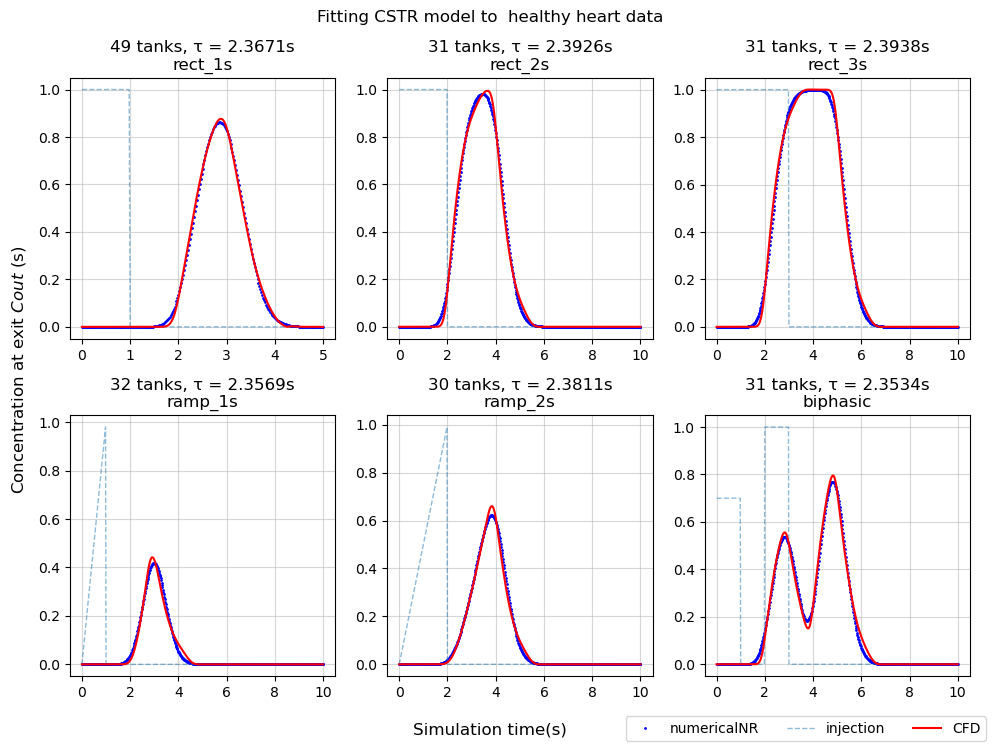

data/Aneurysm_rect_1s.csv
new optimal tau found 2.5071s, >N= 10, SSR: 1.6159751087641052
new optimal tau found 2.4973s, >N= 11, SSR: 1.3256962599234505
new optimal tau found 2.4895s, >N= 12, SSR: 1.0904698708690141
new optimal tau found 2.4831s, >N= 13, SSR: 0.9008492133351095
new optimal tau found 2.4778s, >N= 14, SSR: 0.7492807697903855
new optimal tau found 2.4734s, >N= 15, SSR: 0.629655013598543
new optimal tau found 2.4695s, >N= 16, SSR: 0.5369822264502799
new optimal tau found 2.4662s, >N= 17, SSR: 0.4671529516850103
new optimal tau found 2.4633s, >N= 18, SSR: 0.4167576421374157
new optimal tau found 2.4607s, >N= 19, SSR: 0.38294878424223455
new optimal tau found 2.4583s, >N= 20, SSR: 0.3633341337576491
new optimal tau found 2.4562s, >N= 21, SSR: 0.35589312508228677
Minima found at N=21 tanks and τ =2.4562,  using NR in 4 iterations(avg)
--------------------------------------------------------------------------------


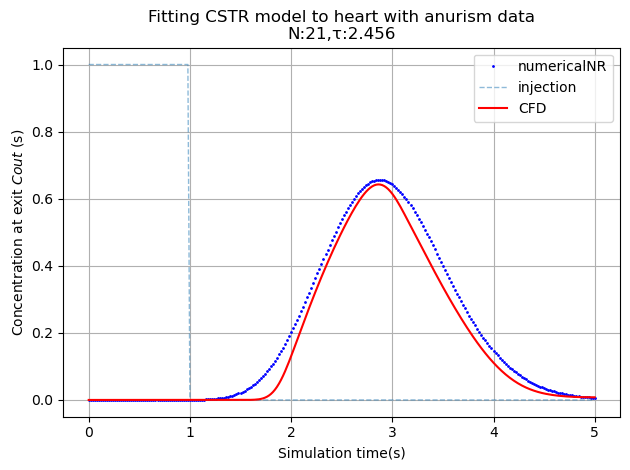

In [23]:
protocol = 'rect_1s'
fig, ax = plt.subplots()
optimal_N_re1s, optimal_tau_re1s = fit_CFD_data(
    healthy=False, protocol=protocol, Ns=range(10, 60), solver='NR', ax=ax)

ax.set_title(f'Fitting CSTR model to heart with anurism data'+f'\nN:{optimal_N_re1s},τ:{optimal_tau_re1s:0.3f}')
ax.set_xlabel(f'Simulation time(s)')
ax.set_ylabel(f'Concentration at exit $Cout$ (s)')
#handles = ax.get_legend_handles_labels()
ax.legend()  # (*handles,loc='lower right', ncol=5)
plt.grid()
plt.tight_layout()

In [24]:
print(f'Flowrate, q = {q:0.2f} ml/min, Optimal τ ={optimal_tau_re1s:.2f}s')
print(f'The total volume of the aorta with aneurysm is {q/60*optimal_tau_re1s:0.2f}mL')

Flowrate, q = 5005.98 ml/min, Optimal τ =2.46s
The total volume of the aorta with aneurysm is 204.93mL


Assuming that the flow rate $q$ is constant, we had arrived at a volume of the aorta with aneurysm of 204.9ml (compared to 197.5ml for healthy aorta); a difference in about 3.7% in volume. Aneurysm being a ballooning of the blood vessel, it is clear that the aorta with aneurysm has a higher volume.  

It should be noted that minimal SSR for the `CSTRModel` aorta with aneurysm is around 10 times higher than that of the minimal SSR for the healthy aorta. This shows the model is not as good a fit when applied to aorta with aneurysm.   

data/Aneurysm_rect_1s.csv
data/Aneurysm_rect_2s.csv
data/Aneurysm_rect_3s.csv
data/Aneurysm_ramp_1s.csv
data/Aneurysm_ramp_2s.csv
data/Aneurysm_biphasic.csv


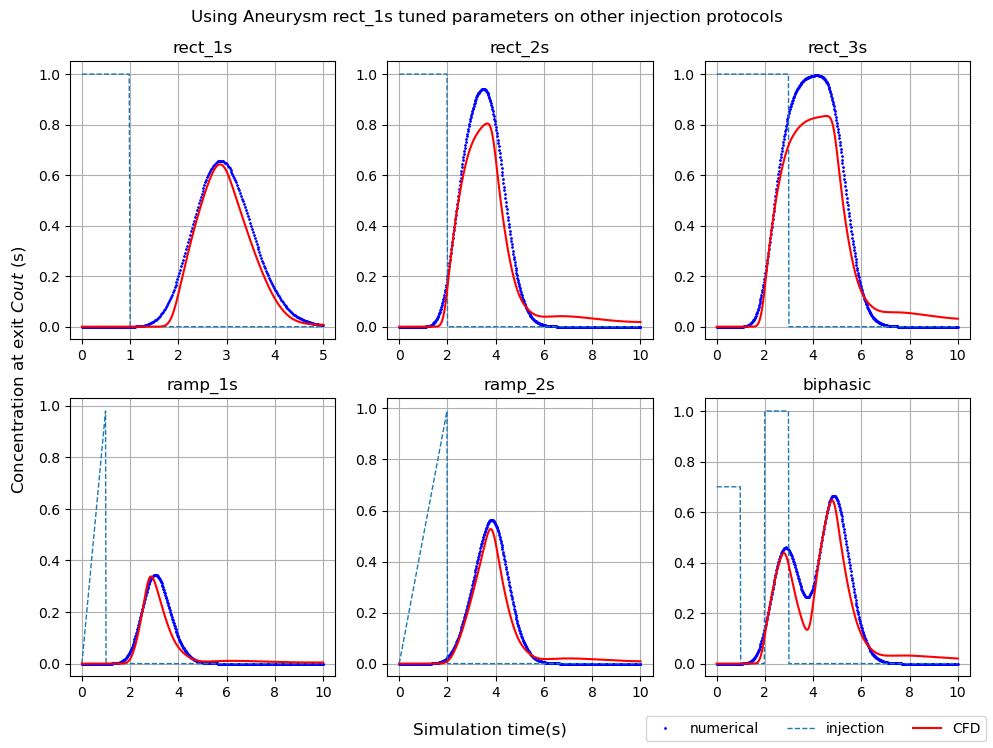

In [25]:
N = optimal_N_re1s
tau = optimal_tau_re1s

protocols = [f'rect_{i}s' for i in [1, 2, 3]] +\
            [f'ramp_{i}s' for i in [1, 2]] +\
            [f'biphasic']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7.5))
axs = np.ndarray.flatten(axs)

for ax, protocol in zip(axs, protocols):
    t, conc_CFD = load_CFD_data(healthy= False, protocol=protocol)
    model = CSTRModel(timedata=t, inj_prot=protocol)
    y = model.time_sim(N=N, tau=tau)
    injection = model.cinj(t)
    
    ax.plot(model.ts, y, 'o', color ='b',
            markersize=1, label='numerical')
    ax.plot(model.ts, injection, '--', markersize=2,
            label='injection', lw=1)
    ax.plot(t, conc_CFD, label='CFD', color= 'r')
    ax.set_title(protocol)
    ax.grid()
fig.suptitle(f'Using Aneurysm rect_1s tuned parameters on other injection protocols ')
fig.supxlabel(f'Simulation time(s)')
fig.supylabel(f'Concentration at exit $Cout$ (s)')
handles = ax.get_legend_handles_labels()
fig.legend(*handles,loc='lower right', ncol=5)
plt.tight_layout()

**Discussion of the plots:**

There is a distinct difference between the CFD data for aneurysm and our model response. As it is discussed in the previous part, the aneurysm changes the flow pattern and the assumption of having perfect mix is incorrect. It seems like the injected tracer accumulated in the aneurysm in the CFD data gets back to main stream slower giving the lower pick in the response and higher tail concentration. 

Our fitting of the CSTR model to the CFD data with aneurysm we arrive at a $\tau$ which is slightly higher than that for a healthy heart: this implies that the tracer stays inside the aorta with aneurysm for longer than for a healthy aorta. 

The optimal number of tanks in our model for a aorta with aneurysm is 21 which is less than half of that we calculated for the healthy aorta. 

Writing the rate of change in concentration of the tracer in tank $i$ we get:
$$ V_i\frac{dC_i}{dt} = q(C_{i-1}-C_i) $$
$$ \frac{dC_i}{dt} = \frac{q}{V_i}(C_{i-1}-C_i)$$
$$ \frac{dC_i}{dt} = \frac{N}{\tau}(C_{i-1}-C_i)$$

Thus the rate of change of the concentration is proportional to the number of tanks in our model. Since the slope of the tracer concentration in the CFD data is lower, our minimizing function reduces the number of tank to match the slope. this is why the optimal number of tanks we arrived at after optimization is lower than that of the healthy aorta data. 

In addition, when an aorta has an aneurysm there is a increase of the volume of one or more of the intermediate tanks and the distribution of the tracer concentration is then governed by a diffusion process which our mixing tank model can not take into account. This is the reason why our model flushes the tracer much quicker but in the CFD model (which captures this diffusion process more faithfully) the tracer accumulates in the internal volume of the aorta and is then gradually leeched out, giving it a very long tail.  


**Part 4: Discuss strengths and weaknesses of the CSTR approach and lessons learnt**

**Strength:**  
1. Simplicity: the model we built was very simple, depending only on a single mass balance equation to model the entire physics of the tracer transport. Despite the simplicity it was able to give quiet good match for healthy heart data, performed by a complex CFD model.  This helps us get some insight into the overall process at the cost of being not very accurate.  
2. Low computation demand: Our model is very quick in performing time domain simulation and we could arrive at a reasonable solution at a fraction of time required when compared to a CFD solver 

  
**Weakness:**  
1. Simplicity: Even if we were able to very easily and quickly fit our model to a injection protocol, it was difficult to achieve reliable results when we apply other slightly complex injection protocols.   
2. 1D solution: the assumption when setting up a continuously stirred mixing tank model is that when a tracer enters a tank it is evenly distributed in the whole volume. This reduces a spatially distributed problem into a single dimension problem and as we saw above is not able to capture the physics of tracer transport with sufficient level of accuracy.
 


# Conclusion

This project allows us to investigate if it is possible to match with Computational Fluid Dynamics (CFD) simulation results by implementing simple approach of a series of N numbered mixing tanks Continuous- Stirred-Tank-Reactor (CSTR) model. We start with theoretical understanding of mass balance equations. We compare the error when using numerical solution by three different methods - Euler, Runge-Kutta second order (RK2) and Runge-Kutta fourth order (RK4). These three method's accuracy was investigate by comparing them with analytical solutions. It is evident that RK4 is the most accurate method among all with varied mixing tank number N = 1,2 and 3(even when using large $\Delta t$) while Euler method displays with higher scale of error in all scenarios. However, RK4 is about 4 times as slow as as the Euler method because it computes the slope 4 times. 

When searching for the optimal parameters of $N$ and $\tau$, least square and gradient descent optimization (learning rate = 0.001 is used) approaches have been applied [3]. Our CSTR model is fitted to two data scenarios - healthy aorta case and aorta with aneurysm case. The results from our CSTR model accurately reproduced the effluent concentration and it demonstrates the great fit of healthy aorta arch. However, aorta with aneurysm behaves differently, as it exhibit deviation to some degree from the CSTR model.

Through our project, we tackled the challenge of address the complexities of modeling real-world systems. In the process, we encountered several noteworthy learning points and obtained insightful findings:

**Understanding the Effects of Numerical Methods:**

One significant aspect of our project was the investigation of numerical methods, including Euler, Runge-Kutta second order, and fourth order. We observed that as we made the time steps (dt) smaller, the impact of rounding errors became more pronounced. Interestingly, even as we aimed for highly accurate solutions, we reached a limit where the total error did not improve beyond a certain point, stabilizing at around 10^-16.

**Compartment Size and Response Time:**

Another vital insight we gained was the relationship between compartment size and response time. Larger compartments exhibited a slower decrease in tracer concentration, while smaller compartments caused delays in the exit response. This highlights the trade-off between modeling complexity and capturing the fine details of a system's behavior.

**Model Fitting and Aneurysm Detection:**

We extensively explored the process of fitting our models to Computational Fluid Dynamics (CFD) results, both for healthy and unhealthy aortas (with aneurysms) across various injection protocols. In the case of healthy aortas, we observed that the optimal Tau value was consistently similar for all injection protocols, with a mean of approximately 2.3742 and a standard deviation of 0.0161. The number of compartments in the model was also very similar for all protocols, except 'rect_1s,' which required more compartments.

For unhealthy aortas with aneurysms, we noticed an increase in the optimal Tau value, indicating the enlargement of the aorta due to the aneurysm. The analysis of responses to 'rect_1s' protocol in healthy and unhealthy aorta allowed us to estimate the aneurysm volume to be about 7.4 ml. Furthermore, all models for unhealthy aortas exhibited a reduction in the number of compartments. When comparing the fitted model responses to the CFD results, it became apparent that the CFD responses had lower peaks and longer tails, signifying that the aneurysm impacted the rate of decline in exit concentration. The model aimed to capture this effect by employing larger compartments.

In conclusion, this project provided us with valuable insights into the challenges and opportunities of modeling complex real-world systems. We learned the significance of effective models, the behavior of numerical methods, and the interplay between compartment size and response characteristics. Our model fitting exercises shed light on the potential for diagnosing aneurysms and highlighted the role of various injection protocols in these medical scenarios. These findings enhance our understanding of complex systems and pave the way for further exploration and learning in this field.

------------------------------------
# Reflections:

**Jing:**

This project is challenging but interesting that we can apply the knowledge of ODE models to mimic the complicated CFD simulation results. The approach of Monte Carlo Simulation also provides another alternative to do the fitting. These various ways of implementation and gradient descent put some of my theoretical concepts into practice. That is very rewarding and inspires us to apply it in other relevant scenarios in life.


**Hodjat:**
I gained valuable insights while working on the problem set. The process of exploring and testing more sparked additional questions, for instance when observing changes in error scaling during smaller and smaller time steps. Or having more provided data from CFD led to a curiosity to experiment with different injection protocols and assess the model's performance. I remain intrigued by the variations in fitting parameters across various injection protocols.

I appreciated the flexibility of the questions, allowing me to conduct additional tests. However, I am mindful of the time constraints, as a group member rightly cautioned against delving too deep into unnecessary details. We conducted extra tests beyond the specified questions and provided explanations for them, but there's a possibility of inaccuracies. Feedback on both the main questions and the additional material would be valuable to ensure learning and understanding.

**Partha:**
This project provided opportunity to explore modeling of a problem with very little core competence. It solidified my understanding of classes and i finally understand how much more powerful and flexible they are in creating models and keeping all related data contained in a class object. I further had the opportunity to explore minimization and curve fitting algorithms and have more confidence in building and executing them. The mathematical knowledge in creating models was also very useful. 




### **References**: 
[1] John David Anderson and John Wendt. Computational Fluid Dynamics, volume 206. Springer, 1995.  
[2] H. Scott Fogler and Scott H. Fogler. Elements of Chemical Reaction Engineering. Pearson Educacion, 5 edition, 2020.  
[3] Aksel Hiorth. Modeling and Computational Engineering. https://github.com/ahiorth/CompEngineering, 2022.  
[4] Mayo clinic. Thoracic aortic aneurysm. https://www.mayoclinic.org/diseases-conditions/thoracic-aortic-aneurysm/symptoms-causes/syc-20350188#dialogId25571091 .

[5] H.J Patel and G. M. Deeb, Ascending and Arch Aorta: Pathology, Natural History, and Treatment, doi: 10.1161/CIRCULATIONAHA.107.690933
